<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## PGE 383 Graduate Student Project 


## Random Forest for classification of depositional environments

### Fritz Palacios
#### Jackson School of Geosciences

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Jack Xiao, Graduate Student, The University of Texas at Austin
##### [Twitter](https://twitter.com/jackxiao6) | [LinkedIn](https://www.linkedin.com/in/yuchen-jack-xiao-b1b20876/)


### Executive Summary

Wireline logs contain information about depositional environments, which are generally determined by visual inspection and calibration with cores. Knowing the distribution of depositional environments at regional scale can help us to understand the paleogeography of one area, and therefore, the likely spatial distribution of reservoirs. I classified depositional environments based on the shapes of rock-calibrated wireline logs. Four facies were classified based on Random Forest method. Two different formations were used for training and testing. The model presents a 0.85 of accuracy but works very well when the results are plotted in a map. Therefore, this model can considerably reduce the time of creating maps for an exploratory review of paleography at regional scale. This pilot model considers four facies in one small area, so addition of more facies may be needed for covering bigger areas.

## 1. Import Packages

In [386]:
########## Basic modules
import pandas as pd                   # Manipulate dataframes
import numpy as np                    # Perform numerical operations
import matplotlib.pyplot as plt       # Make visualizations  
import seaborn as sns                 # Make matrix scatter plots
import os                             # define the working folder

########## Data Handling
from sklearn.model_selection import  train_test_split    # Split train and test data

########## Random forest
from sklearn.ensemble import RandomForestClassifier                                  # for creating the Random forest model
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score, f1_score  # for checking the accuracy of the model

########## Improvements
%config InlineBackend.figure_format='retina'    # Improve matplotlib outputs
from matplotlib import colors                   # custom colorbars
import warnings                                 # ignore warnings
warnings.filterwarnings("ignore")

## 2. Load Data

The following workflow applies the .csv file "well_shapes_formation1.csv", which has been generated from wells with Gamma Ray (GR) and Resistivity (RES) logs.

**Reference data**
* **ID** - Well number
* **X & Y** - Coordinates for visualization

The following features are being used in this model:

**Predictor Features**

* **Thickness** - Calculated from the base and top of the formation
* **Net Sand** - Sand thickness of the formation, calculated from logs and calibrated with cores
* **Skewness GR** - First measurement of the GR shape. It works very well to discriminate between uniform, bell and funnel shapes
* **Skewness RES** - First measurement of the Resistivity. It works similar to skewness GR with small differences in oil-bearing intervals
* **Kurtosis GR** - Second measurement of the GR shape. It is useful to spot units with low shale content
* **Kurtosis RES** - Second measurement of the GR shape. It works similar to kurtosis GR 


**Response Feature**
* **Facies** - Depositional environments determined by visual inspection and core descriptions
    * **Facies 1** - Fluvial and estuarine channels (most sandstone and minor mudstone)
    * **Facies 2** - Proximal deltas topped by distributary channels (most mudstone and minor sand)
    * **Facies 3** - Distal deltas (only mudstone)
    * **Facies 4** - Patch reefs (only carbonates)

Basic data loading a checking

In [284]:
# set the working directory (line taken Dr. Pyrcz's workflows)
os.chdir("C:/fritz/python_scripts/pge383_ml_hw")         

In [285]:
#load the dataset and check its content
df = pd.read_csv("well_shapes_formation1.csv")
df.head()

,id,x,y,thickness,net_sand,skew_GR,kurtosis_GR,skew_RES,kurtosis_RES,facies
0,0,1813,4989,26.5,0.0,0.314331,1.910839,-0.042462,1.875629,3
1,1,8303,8029,24.0,0.0,-0.042424,1.975167,-0.065621,1.863228,3
2,2,5466,5610,34.5,12.0,-0.280129,1.922642,0.172156,1.979142,1
3,3,19428,11688,19.0,0.0,0.239273,2.165362,-0.098291,1.868951,3
4,4,-44,632,35.0,10.5,0.353097,2.461864,-0.203916,1.693185,2


In [286]:
# Summary statistics to spot anomalous values
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,135.0,67.000000,39.115214,0.000000,33.500000,67.000000,100.500000,134.000000
x,135.0,11666.800000,4795.821055,-626.000000,8319.500000,11795.000000,14463.500000,22542.000000
y,135.0,7167.140741,3105.068926,-2420.000000,5041.500000,7763.000000,9684.500000,12471.000000
thickness,135.0,27.659207,7.429896,10.500000,22.500000,28.500000,33.000000,49.000000
net_sand,135.0,8.674074,10.900383,0.000000,0.000000,2.500000,14.750000,40.000000
skew_GR,135.0,-0.005775,0.390421,-1.176845,-0.174040,0.069006,0.211557,0.966207
kurtosis_GR,135.0,2.073998,0.448963,1.374182,1.829785,1.958586,2.179927,4.055585
skew_RES,135.0,0.118452,0.336014,-0.474777,-0.132164,-0.005354,0.392803,0.996413
kurtosis_RES,135.0,1.908808,0.232462,1.392130,1.772277,1.850712,2.025343,2.937615
facies,135.0,2.088889,1.047147,1.000000,1.000000,2.000000,3.000000,4.000000


Prepare the predictor and response matrix

In [298]:
x =  df.iloc[:, 3:9].values  # Select predictor features: thickness, net_sand, skew_GR, kurtosis_GR, skew_RES, kurtosis_RES
y =  df['facies'].values      # Select response features: facies

## 3. Basic Data Checking and Visualization

We visualize first the location map with facies and check the amount of data in each facies to elaborate the model

### 3.1 Data location and distribution

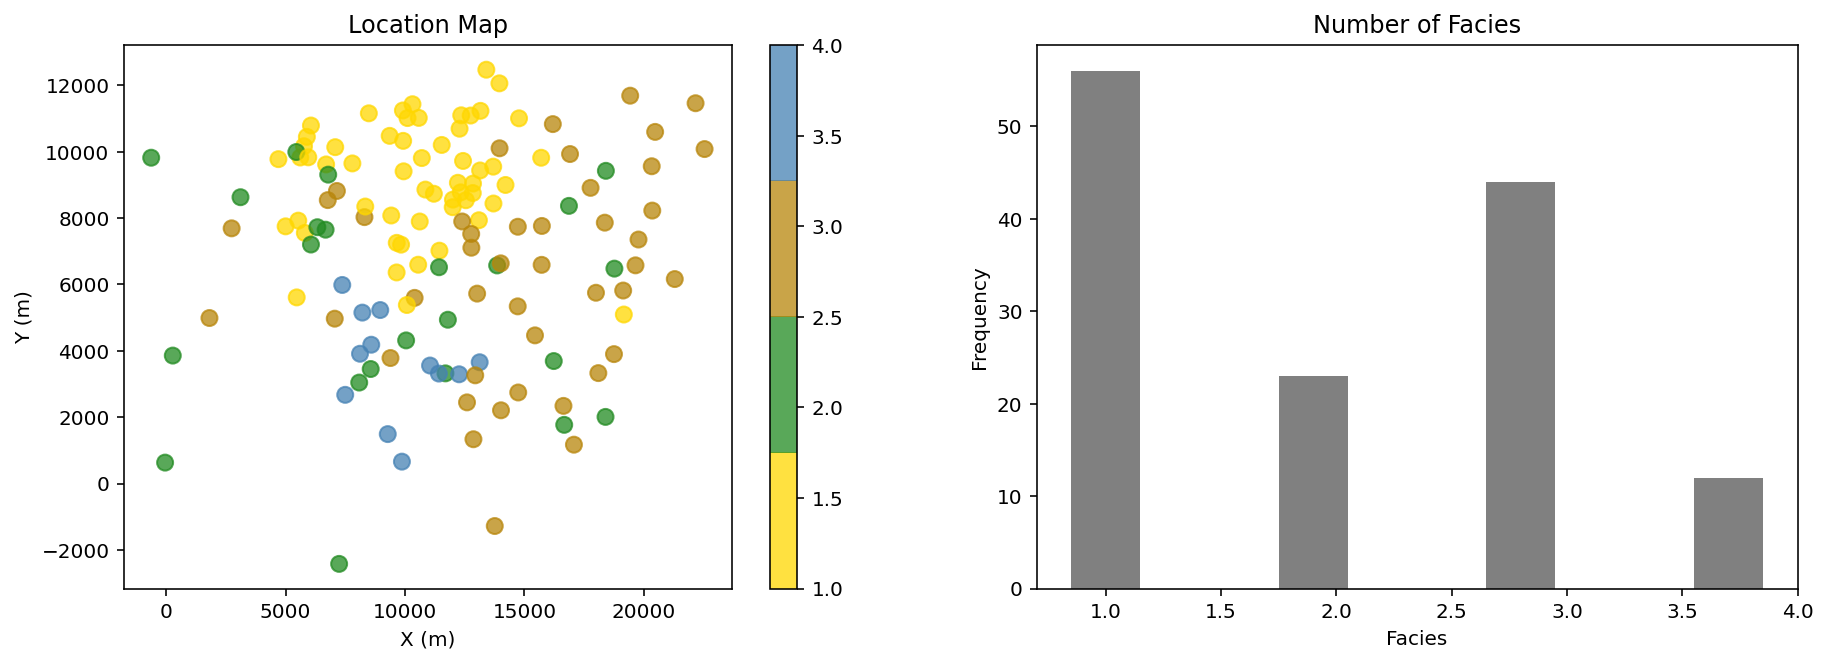

In [399]:
plt.figure(figsize=(15, 5))
cmap4 = colors.ListedColormap(['gold', 'forestgreen', 'darkgoldenrod', 'steelblue'])   # custom color bar (Facies 1, Facies 2, Facies 3, Facies 4)

#Create a location map
plt.subplot(121)
plt.scatter(df['x'], df['y'], s=64, c=df['facies'], cmap=cmap4, alpha=0.75)
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("Location Map")
plt.colorbar()

#Create a histogram of facies
plt.subplot(122)
plt.hist(df['facies'], align='left', color='gray')
plt.xlabel("Facies")
plt.ylabel("Frequency")
plt.title("Number of Facies")

plt.show()

135 wells area used for building the model, in which Facies 1 and 3 are the most abundant

### 3.2 Correlation Matrix

Calculate the correlation matrix

In [299]:
corr_matrix = np.corrcoef(df.iloc[:, 3:9], rowvar = False)
print('Correlation Matrix')
print(np.around(corr_matrix,2))      

Correlation Matrix
[[ 1.    0.57  0.    0.06  0.31  0.12]
 [ 0.57  1.    0.09 -0.19  0.56  0.15]
 [ 0.    0.09  1.   -0.46 -0.36 -0.13]
 [ 0.06 -0.19 -0.46  1.    0.28  0.42]
 [ 0.31  0.56 -0.36  0.28  1.    0.54]
 [ 0.12  0.15 -0.13  0.42  0.54  1.  ]]


Visualize the correlation matrix

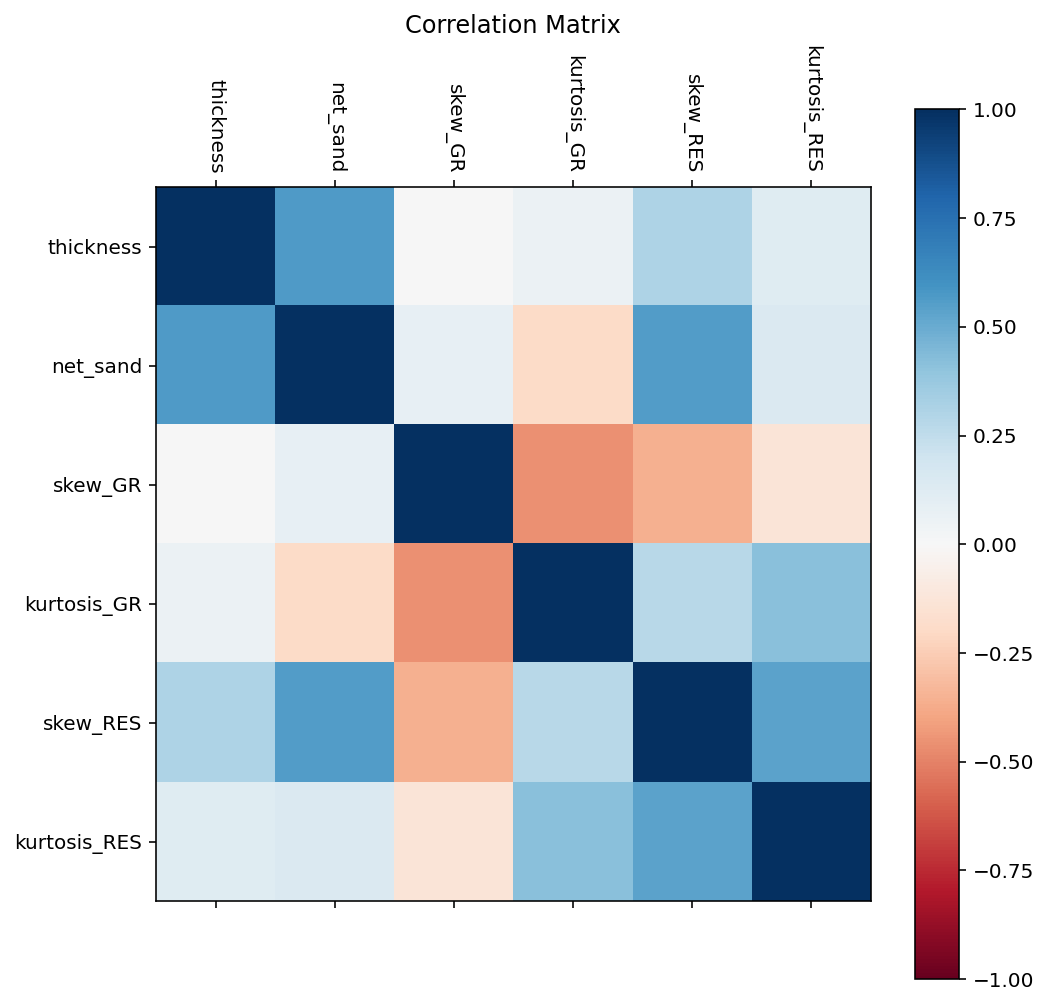

In [300]:
# fuction for plotting the correlation matrix
# modified from Dr. Pyrcz's workflows

def plot_corr(dataframe,size=8,cbarlabel=""):                           
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0, cmap="RdBu")
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.setp(ax.get_xticklabels(), rotation=270)
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
      
# call the matrix visualization function

plot_corr(df.iloc[:, 3:9],8, cbarlabel="Coefficient of correlation")  
plt.show()

We can observe from the correlation matrix that the six predictor features are no colinear, with a maximum correlation coefficient of 0.57 for thickness and net sand. These coefficients can suggest that the six predictor features are independent

### 3.3 Pairwise plot

Pairwise relationships of the six predictor features are generally non-linear, and it is possible to distinguish the four facies by visual inspection

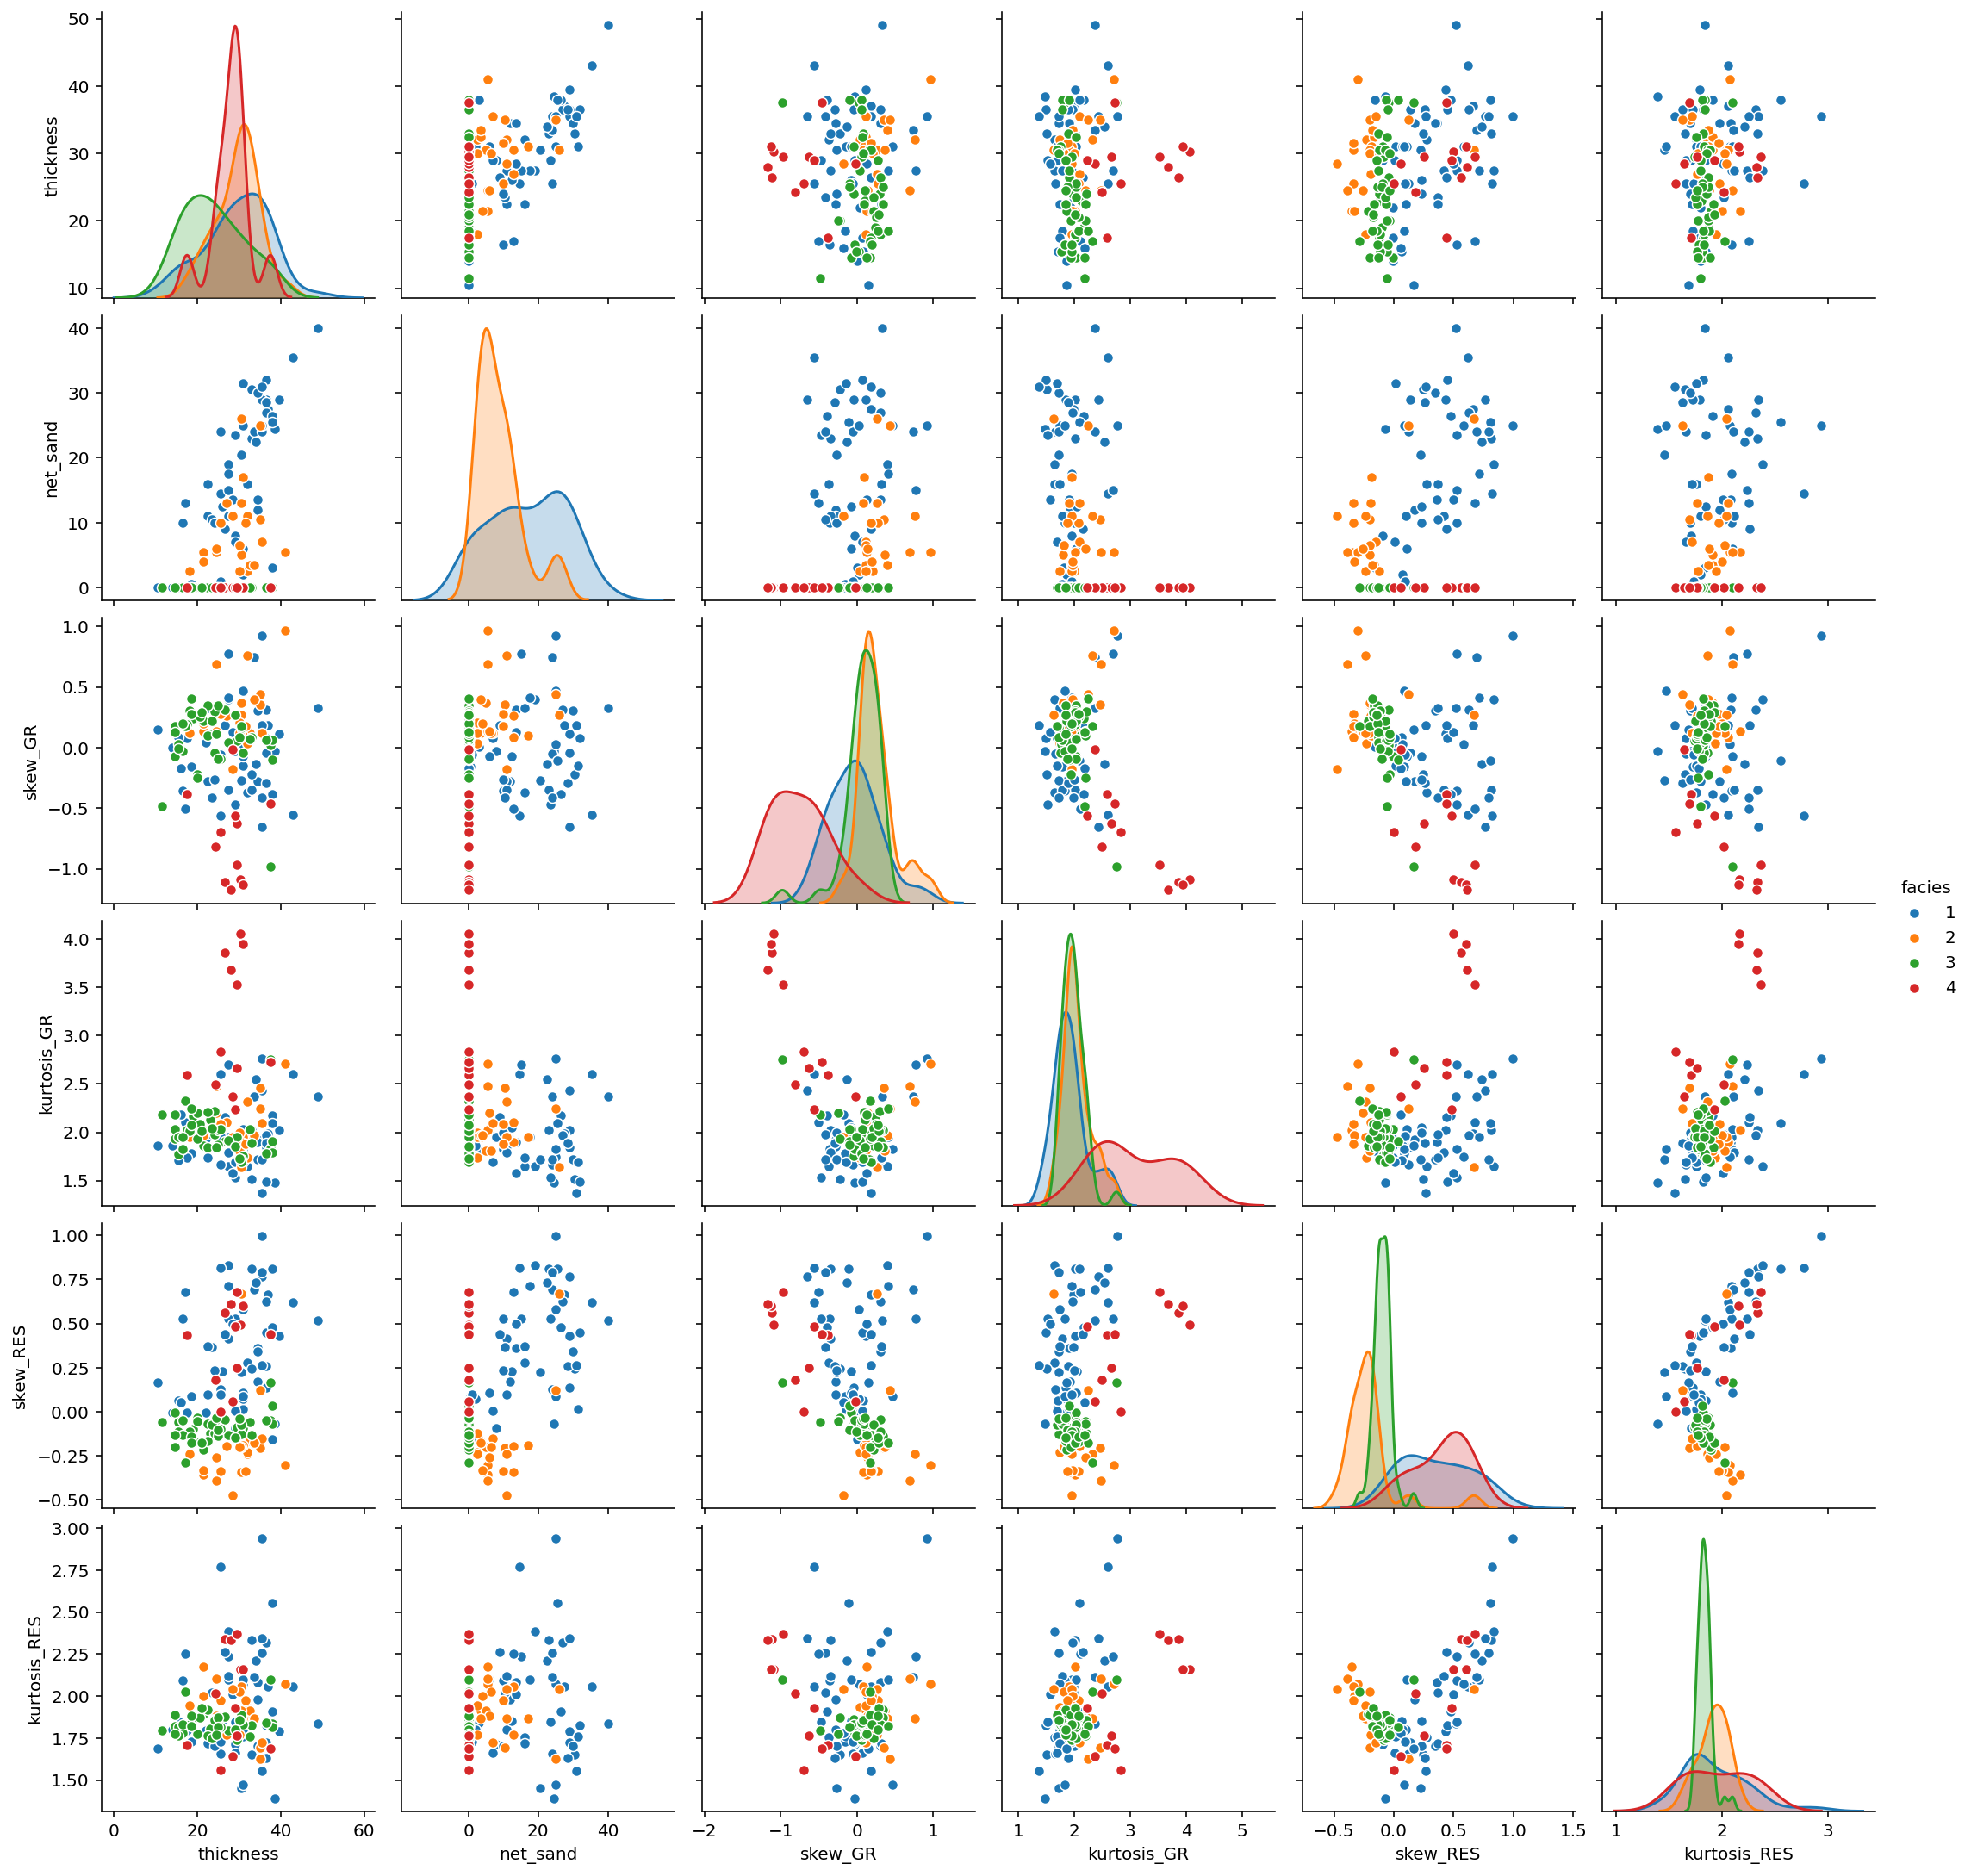

In [301]:
sns.pairplot(df, vars=['thickness','net_sand', 'skew_GR', 'kurtosis_GR', 'skew_RES', 'kurtosis_RES'],  hue="facies")

## 4. Random Forest Method

We selected this method because it follows a similar thinking process when a person correlates wireline logs. The crucial difference is that a person directly sees the shape of the GR and RES curve to assign one facies. In contrast, a pre-processing of the wireline logs was needed to quantify the shapes for building the model.

### 4.1 Initial Model

A train and test data is used to build the initial model

              precision    recall  f1-score   support

           1       0.62      0.59      0.61        17
           2       0.57      0.57      0.57         7
           3       0.47      0.54      0.50        13
           4       1.00      0.75      0.86         4

    accuracy                           0.59        41
   macro avg       0.67      0.61      0.63        41
weighted avg       0.60      0.59      0.59        41

Accuracy Score: 0.59


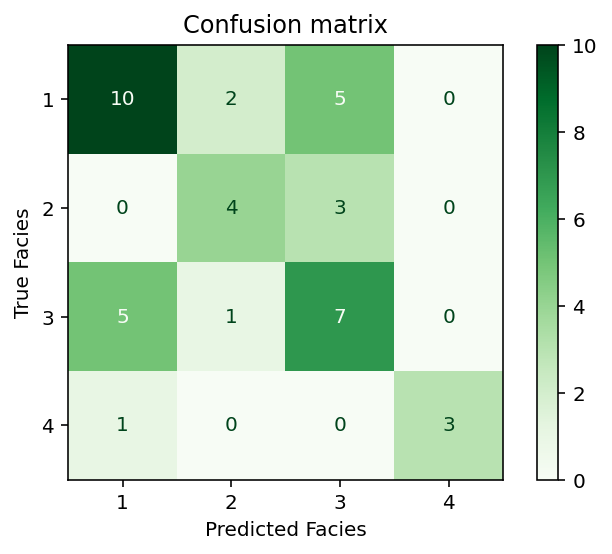

In [367]:
# split train and test data, take 30% for testing and same proportion for each facies
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.3,      # 30% test data
                                                    random_state=5,     # Value selected to have the lowest accuracy at the beginning (avoid overfit)  
                                                    stratify=y)

classifier = RandomForestClassifier(n_estimators=1, random_state=0)             # initialize the random forest model
classifier.fit(x_train, y_train)                                                # run the model from training data
y_pred = classifier.predict(x_test)                                             # prediction based on testing data

print(classification_report(y_test, y_pred))                                    # make a classification report
disp = plot_confusion_matrix(classifier, x_test, y_test, cmap='Greens')         # make confussion matrix
disp.ax_.set_title('Confusion matrix')
disp.ax_.set_xlabel('Predicted Facies')
disp.ax_.set_ylabel('True Facies')

print('Accuracy Score: ' + str(round(accuracy_score(y_test, y_pred),2)))        # calculate the accuracy score

The confusion matrix of the lowest number of trees (n=1) shows an initial accuracy score 0.59, which is mainly influence by the poor model performance for Facies 2 and 3.

### 4.2 Hyperparameter tuning

Number of trees are evaluated to find the best number

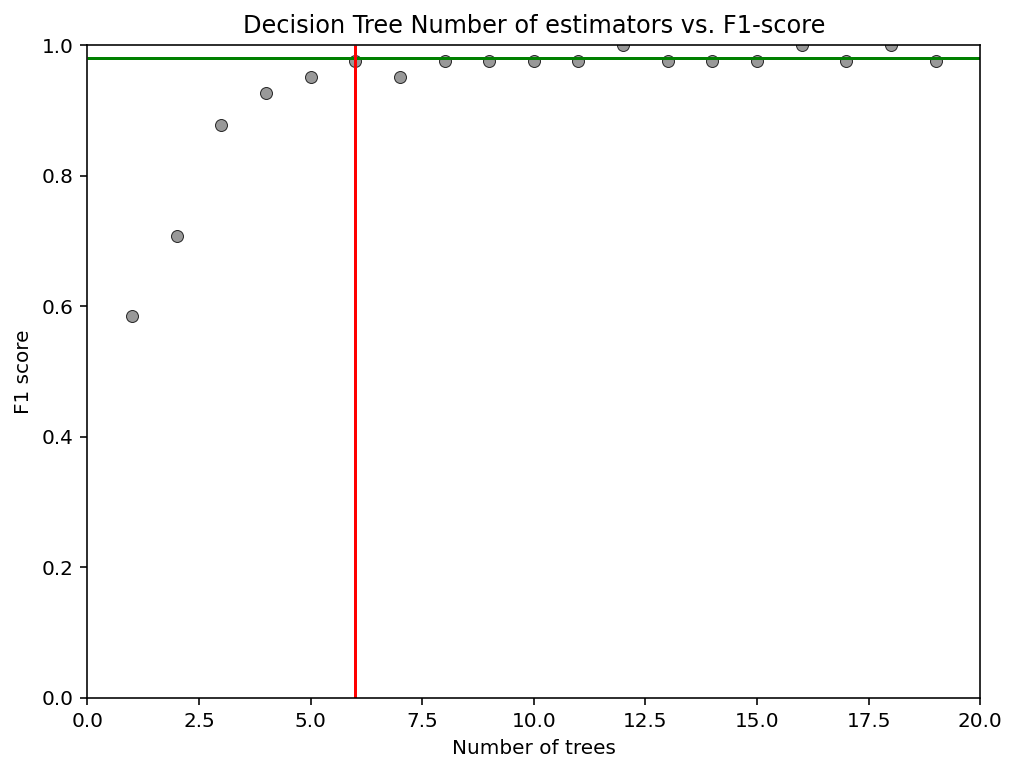

In [369]:
# modified from Dr. Pyrcz's Desicion Tree workflow
score = []                     # code from StackOverFlow by Dimosthenis
node = []
for inodes in range(1,20):                                                       # loop over 20 number of trees
    my_tree = RandomForestClassifier(n_estimators=inodes, random_state=0)        
    my_tree.fit(x_train, y_train)                                                # run the model from training data
    y_pred_tree = my_tree.predict(x_test)   
    scores = f1_score(y_test, y_pred_tree, average='micro')                      # f1 score to evaluate the model performance
    score.append(scores)
    node.append(inodes)

# Plot number of trees vs F1 score
plt.figure(figsize=(8,6))
plt.scatter(node,score,s=None, c="grey", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.5, verts=None, edgecolors="black")
plt.title('Decision Tree Number of estimators vs. F1-score'); plt.xlabel('Number of trees'); plt.ylabel('F1 score')
plt.hlines(0.98, 0, 20, colors='g')
plt.vlines(6, 0, 1, colors='r')
plt.xlim(0,20)
plt.ylim(0,1)
plt.show()

The model becomes stable by using **6 trees** with accuracy of 0.98

### 4.3 Rebuilding the model with the complete dataset

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        56
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00        44
           4       1.00      1.00      1.00        12

    accuracy                           1.00       135
   macro avg       1.00      1.00      1.00       135
weighted avg       1.00      1.00      1.00       135

Accuracy Score: 1.0


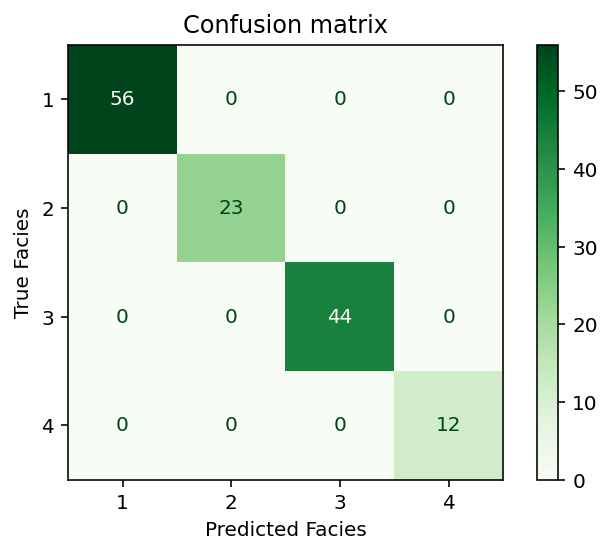

In [370]:
classifier_tuned = RandomForestClassifier(n_estimators=6, random_state=0)             # initialize the random forest model
classifier_tuned.fit(x, y)                                                # run the model from all the dataset
y_total_pred = classifier_tuned.predict(x) 

print(classification_report(y, y_total_pred))                                    # make a classification report
disp = plot_confusion_matrix(classifier_tuned, x, y, cmap='Greens')         # make confussion matrix
disp.ax_.set_title('Confusion matrix')
disp.ax_.set_xlabel('Predicted Facies')
disp.ax_.set_ylabel('True Facies')

print('Accuracy Score: ' + str(round(accuracy_score(y, y_total_pred),2)))        # calculate the accuracy score


The tuned model has a excellent accuracy of 1

## 5. Testing the Model with new data

We use another dataset ("well_shapes_formation2.csv") from a younger formation to check how robust is the tuned model. This formation has same depositional environments with the exception of carbonates (Facies 4).

We load the dataset here to be sure that it was not used in during the model building process

In [326]:
#load the dataset
df_fm2 = pd.read_csv("well_shapes_formation2.csv")
df_fm2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,52.0,25.500000,15.154757,0.000000,12.750000,25.500000,38.250000,51.000000
x,52.0,9718.980769,5024.721994,-626.000000,6763.250000,9335.500000,12796.750000,20472.000000
y,52.0,5946.980769,3577.423591,-2420.000000,3319.500000,5495.500000,9337.750000,12471.000000
thickness,52.0,32.857942,7.121595,16.500000,29.000000,33.750000,36.500000,45.500000
net_sand,52.0,8.692308,11.770749,0.000000,0.000000,3.250000,12.625000,36.000000
skew_GR,52.0,0.201619,0.279952,-0.254254,0.055857,0.137859,0.266285,1.027792
kurtosis_GR,52.0,1.994651,0.282366,1.617465,1.858673,1.915427,2.020858,3.214161
skew_RES,52.0,0.097790,0.356943,-0.488946,-0.117247,-0.050832,0.253316,1.002489
kurtosis_RES,52.0,1.938842,0.309628,1.562236,1.787365,1.838510,1.912097,2.854474
facies,52.0,2.096154,0.846205,1.000000,1.000000,2.000000,3.000000,3.000000


Prepare the predictor and response matrix

In [342]:
x_fm2 =  df_fm2.iloc[:, 3:9].values   # Select predictor features: thickness, net_sand, skew_GR, kurtosis_GR, skew_RES, kurtosis_RES
y_fm2 =  df_fm2['facies'].values      # Select response features: facies

Run the model with the new dataset

In [363]:
classifier2 = RandomForestClassifier(n_estimators=6, random_state=0)             # initialize the random forest model
classifier2.fit(x, y)                                                            # run the model from tuned model
y_fm2_pred = classifier2.predict(x_fm2)                                             # prediction based on new data

print(classification_report(y_fm2, y_fm2_pred))                                    # make a classification report

# Confusion matrix shows an error because of the absence of Facies 4 in formation 2 but it can be visualized by removing the #'s'
#disp = plot_confusion_matrix(classifier2, x_fm2, y_fm2, cmap='Greens')            
#disp.ax_.set_title('Confusion matrix')
#disp.ax_.set_xlabel('Predicted Facies')
#disp.ax_.set_ylabel('True Facies')

print('Accuracy Score: ' + str(round(accuracy_score(y_fm2, y_fm2_pred),2)))        # calculate the accuracy score

              precision    recall  f1-score   support

           1       0.71      0.94      0.81        16
           2       0.90      0.60      0.72        15
           3       0.95      0.95      0.95        21

    accuracy                           0.85        52
   macro avg       0.86      0.83      0.83        52
weighted avg       0.86      0.85      0.84        52

Accuracy Score: 0.85


Accuracy is 0.85 because of the regular performance of Facies 1 and 2. We now visually check the result

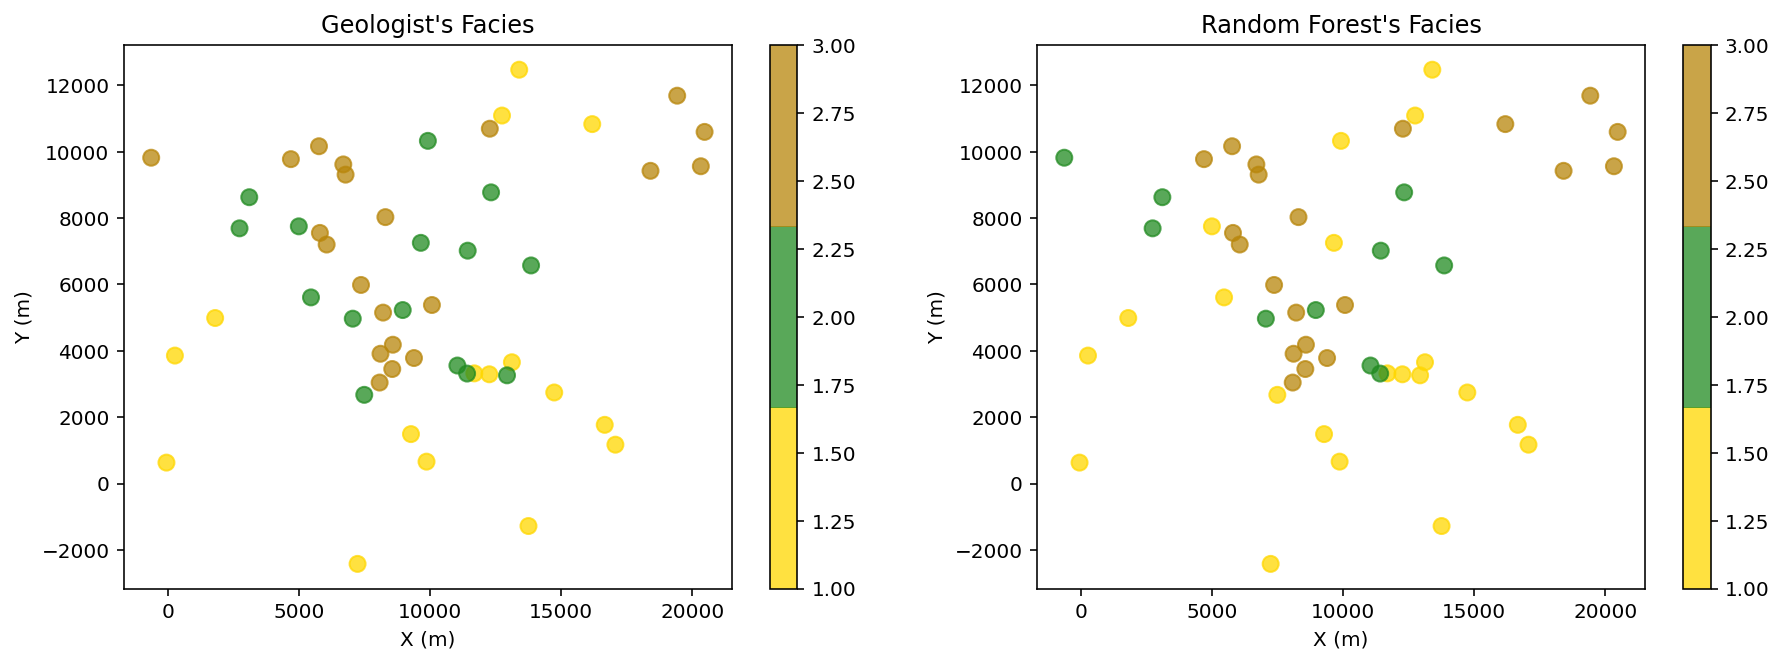

In [406]:
plt.figure(figsize=(15, 5))
cmap3 = colors.ListedColormap(['gold', 'forestgreen', 'darkgoldenrod'])   # custom color bar (Facies 1, Facies 2, Facies 3)

#Create a location map
plt.subplot(121)
plt.scatter(df_fm2['x'], df_fm2['y'], s=64, c=df_fm2['facies'], cmap=cmap3, alpha=0.75)
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("Geologist's Facies")
plt.colorbar()

#Create a histogram of facies
plt.subplot(122)
plt.scatter(df_fm2['x'], df_fm2['y'], s=64, c=y_fm2_pred, cmap=cmap3, alpha=0.75)
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("Random Forest's Facies")
plt.colorbar()
plt.show()

The model visually works very well. Few mismatches can be easily explained by the amount of sand in one specific area (e.g. well-developed sands in Facies 2 that mimic the shape of Facies 1; likewise, poorly-developed sands in Facies 2 that mimic the shape of Facies 3). In general, the map shows similar depositional trends, so the resulting paleogeographic interpretation are the same.

## Final Comments

* This dataset is part of my MS thesis which consisted on manually correlate >5000 wireline logs in the Eastern Shelf of the Permian Basin.
* Due to the large number of wells, facies determination was restricted in small areas.
* This model can help to automatize the determination of depositional environments at regional scale.
* Further enhancements in this model will help the study the paleogeography of the eastern Permian Basin.


* My email is fritz.palacios@utexas.edu for any comment or suggestion.
* For more about me, check out these links:
### [LinkedIn](https://www.linkedin.com/in/fritzpalacios/) |  [ResearchGate](https://www.researchgate.net/profile/Fritz_Palacios)



I hope this was helpful,

### Fritz Palacios
PhD candidate in Geological Sciences


___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
